In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from util.data_loader import (load_dataset, split_train_validation, 
                              custom_random_oversampling, create_csv_submission,
                              change_negative_class)
from util.features_util import keep_features, merge_features
from util.features_info import FEATURES_DICT, REPLACEMENT_LIST
from util.preprocessing import preprocessing_pipeline, basic_preprocessing_pipeline
from util.train import reg_logistic_regression
from util.plotting import loss_visualization, decision_threshold
from util.evaluation import evaluation_summary
from util.predict import predict, predict_no_labels
from util.util import init_random_seeds


BASE_PATH = os.path.dirname(os.getcwd()) + "/data"

init_random_seeds()

# Data loading

### ⚠️ Note that the `x_sub` here refers to data for which predictions will be made, but for which we don't have the labels! To refer to the data used for local testing we'll use `x_va` and `y_va` (validation).

In [2]:
# Load data without subsampling
x_train, y_train, x_sub, feature_names = load_dataset(path_x_train=BASE_PATH + "/x_train.csv",
                                                      path_y_train=BASE_PATH + "/y_train.csv",
                                                      path_x_test=BASE_PATH + "/x_test.csv",
                                                      sub_sample=False)
# Create the feature index dictionary
feature_index = dict(zip(feature_names, range(len(feature_names))))

# Pre-processing

In [3]:
# Keeping only selected features both in train and validation set
x_train_clean, clean_features, clean_feature_index = keep_features(
    x_train,
    FEATURES_DICT.keys(),
    feature_names,
    feature_index,
    verbose=False
)

In [4]:
# Call to the preprocessing pipeline both for train and test set,
# but only on the set of clean features

x_train_clean_proc = preprocessing_pipeline(x_train_clean, 
                                            where=clean_features,
                                            feature_index=clean_feature_index,
                                            nan_replacement=REPLACEMENT_LIST,
                                            normalize="mixed")

# Perform basic preprocessing on the rest of the features
x_train_dirty_proc = basic_preprocessing_pipeline(x_train,
                                                  where=[f for f in feature_names if f not in clean_features],
                                                  feature_index=feature_index,
                                                  normalization="min-max")


In [5]:
x_train_merged = merge_features(x_big=x_train_dirty_proc,
                                feature_index_big=feature_index,
                                x_small=x_train_clean_proc,
                                feature_index_small=clean_feature_index)

## Split local data into train and validation

#### From now on we'll use the local train and validation data: `x_tr` and `y_tr` for training and `x_va` and `y_va` for validation

In [6]:
# Translate labels from -1/1 to 0/1
y_train = change_negative_class(y_train[:, 1], current=-1, new=0)

# Split local data into train and validation
(x_tr, x_va, y_tr, y_va) = split_train_validation(x_train_merged,
                                                  y_train,
                                                  valid_proportion=0.2)

## Data preparation for training

In [7]:
# NO oversampling

# Add bias column to the training and validation data
x_tr_bias = np.append(x_tr, np.ones(shape=(x_tr.shape[0], 1)), axis=1)
x_va_bias = np.append(x_va, np.ones(shape=(x_va.shape[0], 1)), axis=1)


# Training

In [30]:
w, train_loss, valid_loss = reg_logistic_regression(x_tr_bias,
                                                    y_tr,
                                                    x_va_bias,
                                                    y_va,
                                                    lambda_=0.00005, 
                                                    max_iter=5000,
                                                    gamma=0.5,
                                                    batch_size=10000,
                                                    optimizer="sgd",
                                                    w=np.random.random(size=x_tr_bias.shape[1]),
                                                    all_losses=True)


Iteration 0/5000 -> lowest loss inf
Iteration 200/5000 -> lowest loss 0.24380672149785937
Iteration 400/5000 -> lowest loss 0.22866491819894155
Iteration 600/5000 -> lowest loss 0.22341035286342917
Iteration 800/5000 -> lowest loss 0.2210366440158057
Iteration 1000/5000 -> lowest loss 0.21902972987935249
Iteration 1200/5000 -> lowest loss 0.21831834639770145
Iteration 1400/5000 -> lowest loss 0.2181114369200933
Iteration 1600/5000 -> lowest loss 0.21797391829044344
Iteration 1800/5000 -> lowest loss 0.2178035812880314
Iteration 2000/5000 -> lowest loss 0.21769092913237253
Iteration 2200/5000 -> lowest loss 0.21759415975923774
Iteration 2400/5000 -> lowest loss 0.2174867846299919
Iteration 2600/5000 -> lowest loss 0.2174867846299919
Iteration 2800/5000 -> lowest loss 0.21733128636368854
Iteration 3000/5000 -> lowest loss 0.21733128636368854
Iteration 3200/5000 -> lowest loss 0.21733128636368854
Iteration 3400/5000 -> lowest loss 0.21733128636368854
Iteration 3600/5000 -> lowest loss 0.2

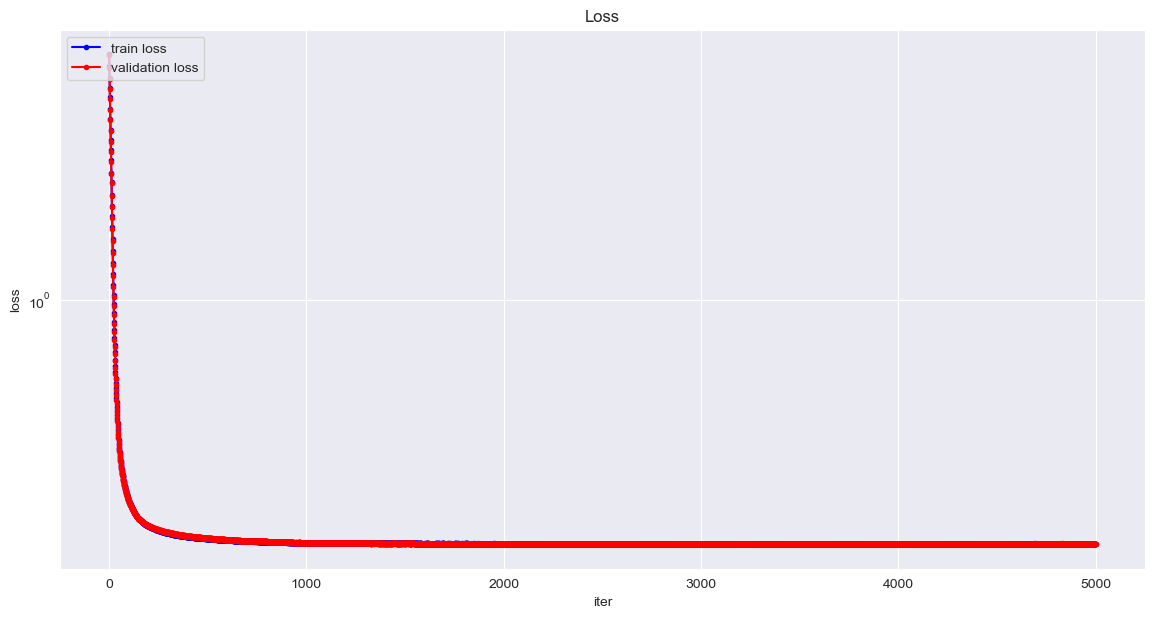

In [32]:
# plot losses
loss_visualization(train_loss, valid_loss)
plt.yscale("log")

# Evaluation on validation set

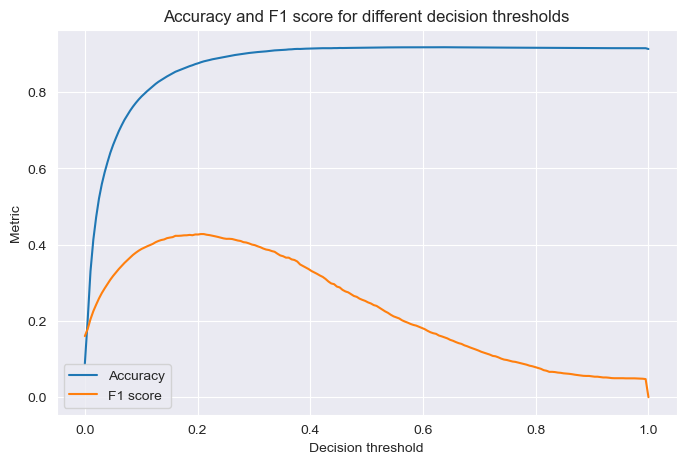

EVALUATION SUMMARY ON VALIDATION SET
Accuracy: 87.83%
Precision: 36.21%
Recall: 52.28%
F1-score: 42.78%
 -> optimal threshold: 0.20603015075376885


In [35]:
threshold_opt = decision_threshold(x_va_bias, w, y_va)
predicted_y_va = predict(x_va_bias,
                         w,
                         threshold=threshold_opt,
                         negative_label=0)
print("EVALUATION SUMMARY ON VALIDATION SET")
evaluation_summary(y_va, predicted_y_va)
print(" -> optimal threshold: {}".format(threshold_opt))

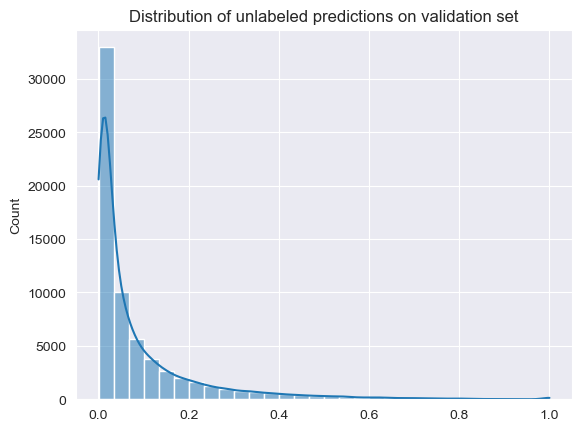

In [36]:
sns.histplot(predict_no_labels(x_va_bias, w), bins=30, kde=True)
plt.title("Distribution of unlabeled predictions on validation set")
plt.show()


---

# COMPUTE RESULT FOR SUBMISSION

## Pre processing and data preparation

In [37]:
# Keeping only selected features both in train and validation set
ids = x_sub[:, 0]
x_sub_clean, clean_features, clean_feature_index = keep_features(x_sub,
                                                                 FEATURES_DICT.keys(),
                                                                 feature_names,
                                                                 feature_index,
                                                                 verbose=False)

In [38]:
# Call to the preprocessing pipeline both for submission set,
# but only on the set of clean features

x_sub_clean_proc = preprocessing_pipeline(x_sub_clean,
                                          where=clean_features,
                                          feature_index=clean_feature_index,
                                          nan_replacement=REPLACEMENT_LIST,
                                          normalize="mixed")

# Perform basic preprocessing on the rest of the features
x_sub_dirty_proc = basic_preprocessing_pipeline(x_sub,
                                                where=[f for f in feature_names if f not in clean_features],
                                                feature_index=feature_index,
                                                normalization="min-max")

x_sub_merged = merge_features(x_big=x_sub_dirty_proc,
                              feature_index_big=feature_index,
                              x_small=x_sub_clean_proc,
                              feature_index_small=clean_feature_index)

x_sub_bias = np.append(x_sub_merged,
                       np.ones(shape=(x_sub_merged.shape[0], 1)),
                       axis=1)

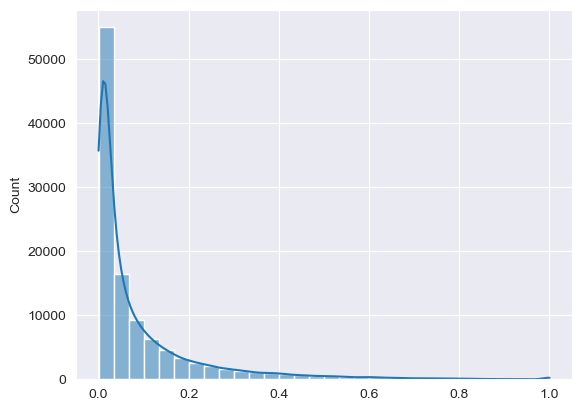

In [39]:
predicted_y_sub = predict(x_sub_bias,
                          w,
                          threshold=threshold_opt,
                          negative_label=-1)

sns.histplot(predict_no_labels(x_sub_bias, w), bins=30, kde=True)
plt.show()

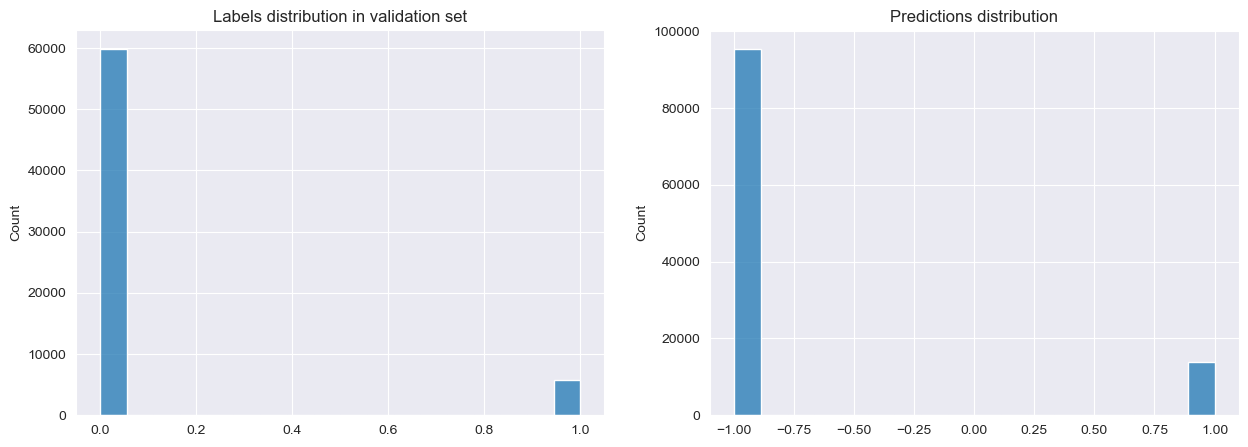

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(y_va, ax=axs[0])
axs[0].set_title("Labels distribution in validation set")
sns.histplot(predicted_y_sub, ax=axs[1])
axs[1].set_title("Predictions distribution")
plt.show()

In [18]:
# Save predictions to csv file
create_csv_submission(ids=ids, y_pred=predicted_y_sub, path=BASE_PATH + "/submission.csv")